Taken from here:
https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders/log

# Unsupervised Learning with Auto-Encoders

If you are interested in an introduction to auto-encoders, head over to [Julien Despois' article](https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df).
If a more technical breakdown is what you are looking for, check out [Lilian Weng's blog post](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html) from which the below image is sourced.
It illustrates the functioning of an auto-encoder for MNIST images, but the concept is the same.
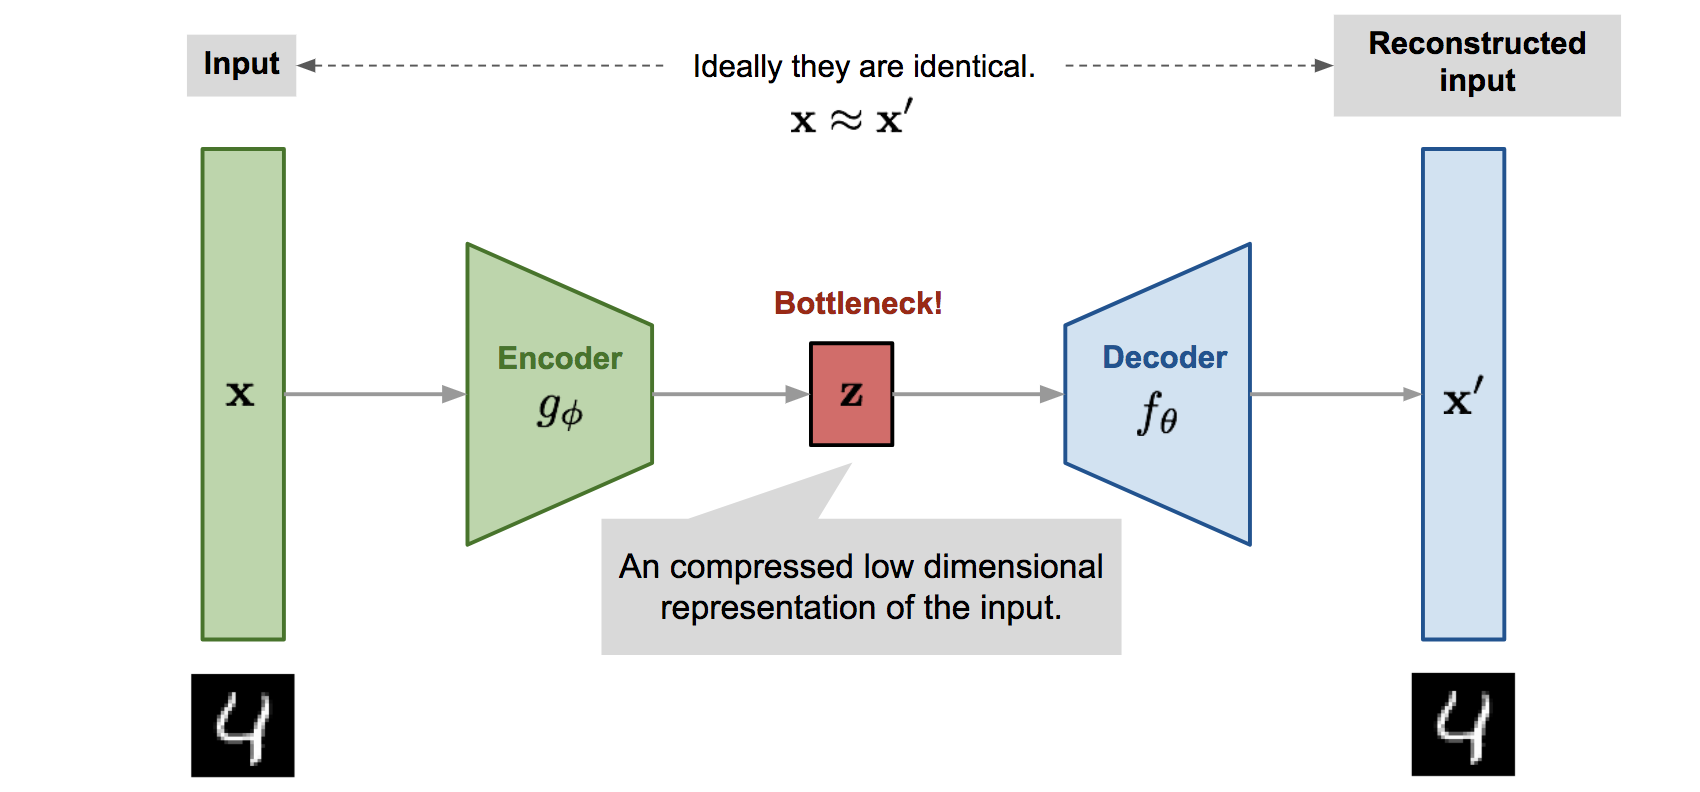

The idea is quite straightforward:
1. Due to the **bottleneck architecture** of the neural network, it is forced to learn a **condensed representation** from which to reproduce the original input.
2. We feed it **only normal transactions**, which it will learn to reproduce with high fidelity.
3. As a consequence, if a **fraud transaction is sufficiently distinct** from normal transactions, the auto-encoder will have trouble reproducing it with its learned weights, and the subsequent **reconstruction loss will be high**.
4. Anything above a specific loss (treshold) will be **flagged as anomalous** and thus labeled as fraud.

# Preprocessing

## Import Libraries & set Random Seeds

In [1]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

# misc
import random as rn

# load the dataset
df = pd.read_csv('data/creditcard.csv')

# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
# tf.set_random_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

%matplotlib inline


## Renaming columns

In [2]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Calculated field: log10(amount)

Turn the amount feature into a normally distributed log equivalent.

In [3]:
# add a negligible amount to avoid taking the log of 0
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [4]:
# keep the label field at the back
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] + 
    ['log10_amount', 'label']
]

# Visualising clusters with t-SNE
*t-Distributed Stochastic Neighbor Embedding (t-SNE)*

From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html): <br>
> t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In plain English, most certainly oversimplifying matters: **t-SNE is a dimensionality reduction technique used for visualisations** of complex datasets.
It **maps clusters in high-dimensional data** to **a two- or three dimensional plane** so we can get an idea of how easy it will be to **discriminate between classes**.
It does this by trying to keep the distance between data points in lower dimensions proportional to the probability that these data points are neighbours in the higher dimensions.

A more elaborate [introduction](https://www.datacamp.com/community/tutorials/introduction-t-sne) is available on DataCamp.

## Undersampling the non-fraud
To keep the computation time low, let's feed t-SNE only a small subsample (undersampling the clean transactions).

In [5]:
# manual parameter 
RATIO_TO_FRAUD = 10

# dropping redundant columns
df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1]
clean = df[df.label == 0]

# undersample clean transactions
clean_undersampled = clean.sample(
    int(len(fraud) * RATIO_TO_FRAUD),
    random_state=RANDOM_SEED
)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels 
features, labels = visualisation_initial.drop('label', axis=1).values, \
                   visualisation_initial.label.values

In [6]:
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 284,315 to 4,920.
This represents a ratio of 10:1 to fraud.


## t-SNE output

In [7]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

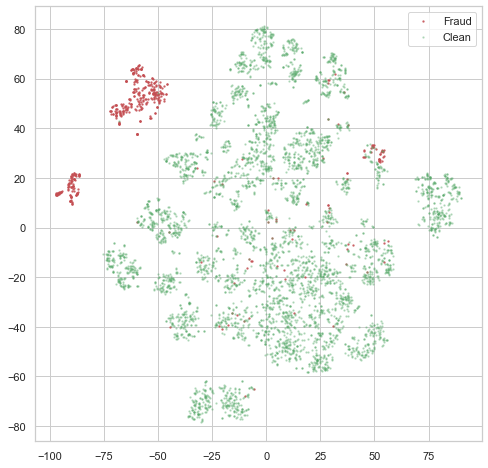

In [8]:
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

Some clusters are apparent, but a minority of fraud transactions remains sneaky, sneaky.

# Train/Validate/Test split
Our auto-encoder will **only train on transactions that were normal**. 
What's left over will be combined with the fraud set to form our test sample.

We will be doing something akin to the below:
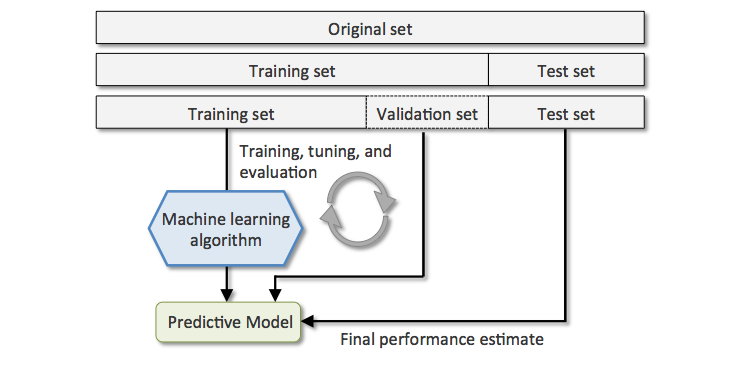
 

1. Training: only non-fraud
    * Split into:
        1. Actual training of our autoencoder
        2. Validation of the neural network's ability to generalize
2. Testing : mix of fraud and non-fraud
    * Treated like new data
    * Attempt to locate outliers
        1. Compute reconstruction loss
        2. Apply threshold

In [9]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (284315, 30)
    fraud (rows, cols) = (492, 30)


In [10]:
# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True)

# training set: exlusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# testing  set: the remaining non-fraud + all the fraud 
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

In [11]:
print(f"""Our testing set is composed as follows:

{X_test.label.value_counts()}""")

Our testing set is composed as follows:

0    84315
1      492
Name: label, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they're all clean anyway
X_train, X_validate = train_test_split(X_train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1).values, X_test.label.values

## Summary

In [13]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 29)
    validate (rows, cols) = (40000, 29)
    holdout  (rows, cols) = (84807, 29)


# Normalising & Standardising 

## Why
In an [excellent article by Jeremy Jordan](https://www.jeremyjordan.me/batch-normalization/), it is explained why making sure your data is normally distributed can **help stochastic gradient descent converge** more effectively.
In a nutshell:
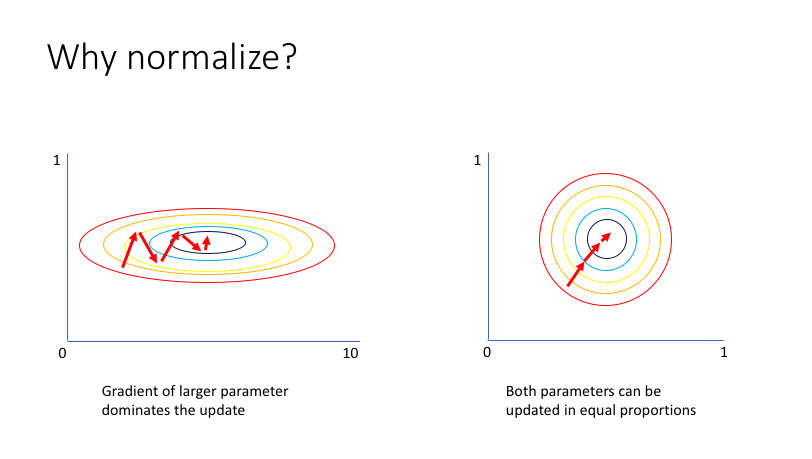


## When
At what point in the data processing do we apply standardisation/normalisation? <br>
An [excellent answer was provided on StackOverflow](https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data).

> Don't forget that **testing data points represent real-world data**. Feature normalization (or data standardization) of the explanatory (or predictor) variables is a technique used to center and normalise the data by subtracting the mean and dividing by the variance. **If you take the mean and variance of the whole dataset you'll be introducing future information into the training explanatory variables** (i.e. the mean and variance).
> 
> Therefore, you should **perform feature normalisation over the training data**. Then **perform normalisation on testing **instances as well, but this time **using the mean and variance of training** explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.
>
> <span style="font-size:10px">[Answer by [Giorgos Myrianthous](https://stackoverflow.com/users/7131757/giorgos-myrianthous)]</span>

## Building our pipeline

In [14]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

## Fitting the pipeline

In [15]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

## Applying transformations with acquired parameters

In [16]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

## Before & After

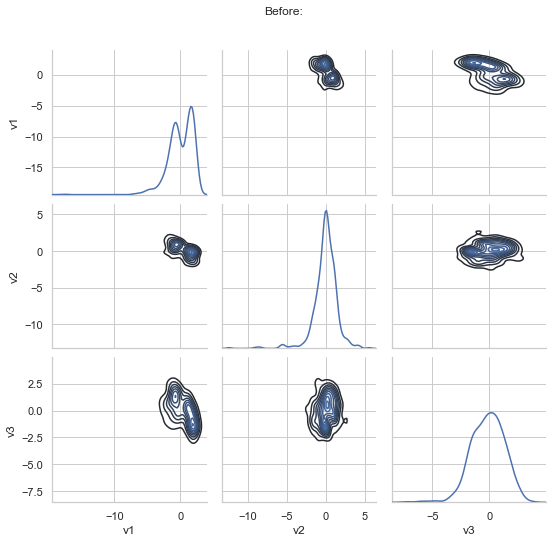

In [17]:
g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

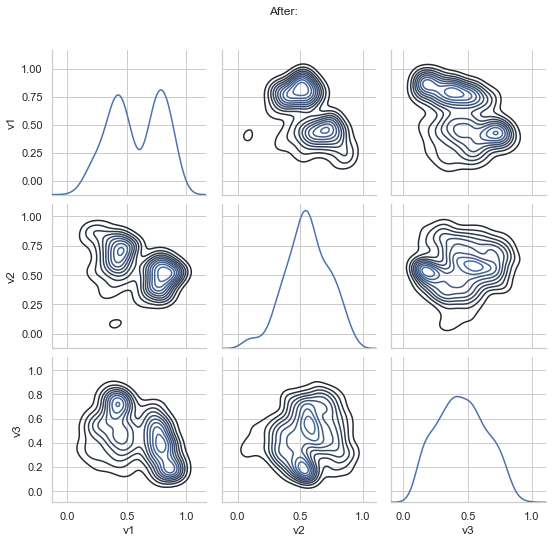

In [18]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

We can tell the data is slightly more **uniform and proportionally distributed**. <br>
The ranges were also shrunk to fit **between 0 and 1**.

# Training the auto-encoder

## TensorBoard
As documented in [this kernel by Aurelio Agundez](https://www.kaggle.com/aagundez/using-tensorboard-in-kaggle-kernels), TensorBoard requires a running kernel, so its output will only be available in an editor session.
Fork this notebook if you wish to interact with it.

In [19]:
# Load the extension and start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17760), started 0:26:10 ago. (Use '!kill 17760' to kill it.)

## Architecture of our model
Keras has become the standard high-level API within Tensorflow. No surprise, it's awesome.
Check out their [blog post on the topic of autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html).

In [20]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
latent_dim = 2
BATCH_SIZE = 256
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    
    # adding some noise to the input data should help it generalize better
    tf.keras.layers.GaussianNoise(0.05),
    
    # compressed representation
    tf.keras.layers.Dense(latent_dim, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/optimizers/
autoencoder.compile(optimizer='adam', 
                    loss='mse',
                    metrics=['acc'])

# print an overview of our model
autoencoder.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                870       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 60        
_________________________________________________________________
dense_2 (Dense)              (None, 29)                87        
Total params: 1,017
Trainable params: 1,017
Non-trainable params: 0
_________________________________________________________________


## Callbacks

* Continue as long as the model is reducing the training loss.
* Save only the weights for the model with the lowest validation loss, though.
* Get graphical insights with Tensorboard.

In [21]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.00005,
    patience=3,
    verbose=1, 
    mode='min',
    restore_best_weights=False
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

## Training

In [22]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    epochs=EPOCHS,
    callbacks=cb,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 0.1452 - acc: 0.0929 - val_loss: 0.0169 - val_acc: 0.1993
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0170 - acc: 0.2048 - val_loss: 0.0165 - val_acc: 0.2235
Epoch 3/100
625/625 [==============================] - 2s 2ms/step - loss: 0.0165 - acc: 0.2169 - val_loss: 0.0161 - val_acc: 0.2253
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0162 - acc: 0.2255 - val_loss: 0.0158 - val_acc: 0.2321
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0159 - acc: 0.2287 - val_loss: 0.0154 - val_acc: 0.2357
Epoch 6/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0154 - acc: 0.2331 - val_loss: 0.0150 - val_acc: 0.2456
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0149 - acc: 0.2544 - val_loss: 0.0146 - val_acc: 0.2860
Epoch 8/100
625/625 [==============================] - 1s 2ms/step - 

In [23]:
# !pip install h5py
import h5py

# Reconstructions

We **apply the transformation pipeline to our test set**. <br>
Then, we **pass the data through the trained autoencoder**.

In [24]:
# transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

**Calculate the reconstruction loss** for every transaction and draw a sample.

In [25]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

In [26]:
# set to whatever you like
sample_size = 30

# showing the reconstruction losses for a subsample of transactions
print(f'Mean Squared Error reconstruction losses for {sample_size} clean transactions:')
print(mse[np.where(y_test==0)][:sample_size])
print(f'\nMean Squared Error reconstruction losses for {sample_size} fraudulent transactions:')
print(mse[np.where(y_test==1)][:sample_size])

Mean Squared Error reconstruction losses for 30 clean transactions:
[0.56185171 0.48413197 0.50247482 0.56420657 1.13945199 0.72409977
 1.0871118  1.18226636 1.36762736 1.17277266 1.09485353 0.84454432
 0.93506416 0.48121935 0.81177192 0.38267391 0.57531796 0.80325082
 0.63434515 0.72012413 0.36390577 0.98011364 0.95081692 0.41304819
 0.47494842 1.5253673  0.39961546 0.47451291 1.10048854 1.63148616]

Mean Squared Error reconstruction losses for 30 fraudulent transactions:
[  5.5308184   99.72550981   0.42738554  28.8302183   29.17522193
  10.95722226  16.43898206   5.36061766   8.20697141   5.05777328
   1.28981019  10.97965168  24.67768733   5.02775826  72.36468353
  12.0826202   10.51988128   1.33289739   9.39256137  11.58797192
   3.87276377  15.57461315   4.91696076  77.04788019 106.43136627
 127.03696263   6.29036794  11.22327932  90.42001654   6.01696552]


Very promising! Although some transactions seem to fool the autoencoder, the fraudulent transactions clearly have a distinguishing element in their data that sets them apart from clean ones. 

# Setting a threshold for classification

## Unsupervised
Normally, in an unsupervised solution, this is where the story would end. We would **set a threshold that limits the amount of false positives** to a manageable degree, **and captures the most anomalous data points**.

### Percentiles 
We could set this threshold by taking the top x% of the dataset and considering it anomalous.

### MAD
We could also use a **modified Z-score using the Median Absolute Deviation to define outliers** on our reconstruction data. Here is a [good blog post on the topic](https://medium.com/james-blogs/outliers-make-us-go-mad-univariate-outlier-detection-b3a72f1ea8c7) by João Rodrigues, illustrating why this algorithm is more robust and scalable than the percentiles method.

In [27]:
# modified version of: www.stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def detect_mad_outliers(points, threshold=3.5):  
    
    # calculate the median of the input array
    median = np.median(points, axis=0)
    
    # calculate the absolute difference of each data point to the calculated median
    deviation = np.abs(points - median)
    
    # take the median of those absolute differences
    med_abs_deviation = np.median(deviation)
    
    # 0.6745 is the 0.75th quartile of the standard normal distribution,
    # to which the MAD converges.
    modified_z_score = 0.6745 * deviation / med_abs_deviation
    
    # return as extra information what the original mse value was at which the threshold is hit
    # need to find a way to compute this mathematically, but I'll just use the index of the nearest candidate for now
    idx = (np.abs(modified_z_score - threshold)).argmin()
    threshold_value = points[idx]

    return modified_z_score, threshold_value

# adjust this parameter to customise the recall/precision trade-off
Z_SCORE_THRESHOLD = 3

# find the outliers on our reconstructions' mean squared errors
mad_z_scores, threshold_value = detect_mad_outliers(mse, threshold=Z_SCORE_THRESHOLD)
mad_outliers = (mad_z_scores > Z_SCORE_THRESHOLD).astype(int)

In [28]:
anomalies = len(mad_outliers[mad_outliers==True])
total_trades = len(y_test)

print(f"""MAD Z-score > {Z_SCORE_THRESHOLD} is the selected threshold.
I.e. any trade with a mean squared reconstruction error >= {threshold_value:,.2f} is flagged.

This results in {anomalies:,} detected anomalies, or {anomalies/total_trades*100:.2f}% out of {total_trades:,} trades reported.""")

MAD Z-score > 3 is the selected threshold.
I.e. any trade with a mean squared reconstruction error >= 2.17 is flagged.

This results in 5,618 detected anomalies, or 6.62% out of 84,807 trades reported.


## Semi-Supervised
However, us still **having access to the labels** means we can assess our model's performance more in-depth and fine tune it.

### Visualising the Anomaly Classification
We can plot the mean squared errors against the selected threshold to get an idea of how successful our method is.
Note that we take the log10 of the mse, to help visualisation. 

C:\Users\install_1407\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


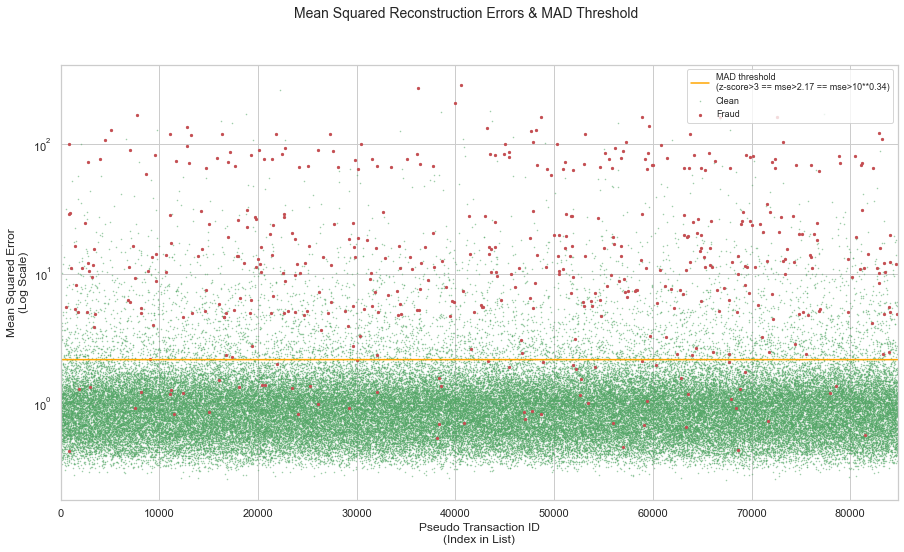

In [29]:
# so we can plot separately and thus customise for each class 
# (we have to retain the index number as the pseudo transaction id)
data = np.column_stack((range(len(mse)), mse))

# scatter's x & y
clean_x, clean_y = data[y_test==0][:,0], data[y_test==0][:,1]
fraud_x, fraud_y = data[y_test==1][:,0], data[y_test==1][:,1]

# instantiate new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot reconstruction errors
ax.scatter(clean_x, clean_y, s=0.25, color='g', alpha=0.6, label='Clean')
ax.scatter(fraud_x, fraud_y, s=5.00, color='r', alpha=1,   label='Fraud')

# MAD threshold line
ax.plot([threshold_value for i in range(len(mse))], color='orange', linewidth=1.5, 
        label=f'MAD threshold\n(z-score>{Z_SCORE_THRESHOLD} == mse>{threshold_value:.2f} == mse>10**{np.log10(threshold_value):.2f})')

# change scale to log & limit x-axis range
ax.set_yscale('log')
ax.set_xlim(0, len(mse))

# title & labels
fig.suptitle('Mean Squared Reconstruction Errors & MAD Threshold', fontsize=14)
ax.set_xlabel('Pseudo Transaction ID\n(Index in List)')
ax.set_ylabel('Mean Squared Error\n(Log Scale)')

# orange legend for threshold value
ax.legend(loc='upper right', prop={'size': 9})

# display
fig.show();

### Classification Matrix on MAD outliers
A closer look:

In [30]:
from sklearn.metrics import confusion_matrix

# get (mis)classification
cm = confusion_matrix(y_test, mad_outliers)

In [31]:
print(f'The classifications using the MAD method with threshold={Z_SCORE_THRESHOLD} are as follows:\n{cm}\n')
print(f'Fraud caught successfully (recall):\n{cm[1,1]} / ({cm[1,0]} + {cm[1,1]}) = {cm[1,1] / (cm[1,0] + cm[1,1]) * 100:.2f}%')

The classifications using the MAD method with threshold=3 are as follows:
[[79130  5185]
 [   59   433]]

Fraud caught successfully (recall):
433 / (59 + 433) = 88.01%


### Asymmetric error cost
In the real world, we can expect **different costs associated with reporting a false positive versus reporting a false negative**. Missing a fraud case is likely to be much more costly than wrongly flagging a transaction as one. In [another kernel](https://www.kaggle.com/robinteuwens/fraud-detection-as-a-cost-optimization-problem/comments), I discuss an approach to determining these costs for this dataset in depth. 

### Recall & Precision
Generally speaking, you will have to prioritise what you find more important. This dilemma is commonly called the **"recall vs precision" trade-off**.
If you want to increase recall, **adjust the MAD's Z-Score threshold** downwards, if you want recover precision, increase it.

# Latent Space 
It is always interesting to look at the **compressed representation** our neural network devised.

## Encoder
Let's build the encoder that gets us to the bottleneck. We take the layers from our autoencoder.

In [32]:
encoder = tf.keras.models.Sequential([
    autoencoder.layers[0],
    autoencoder.layers[1],
    autoencoder.layers[2]
])

## Undersampling
Consistent with the previous t-sne visualisation, let's undersample the clean transactions.

In [33]:
# taking all the fraud, undersampling clean
fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0][:len(fraud) * RATIO_TO_FRAUD, ]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

Clean transactions downsampled from 84,315 to 4,920.
Shape of latent representation: (5412, 2)


## Visualising the Latent Space

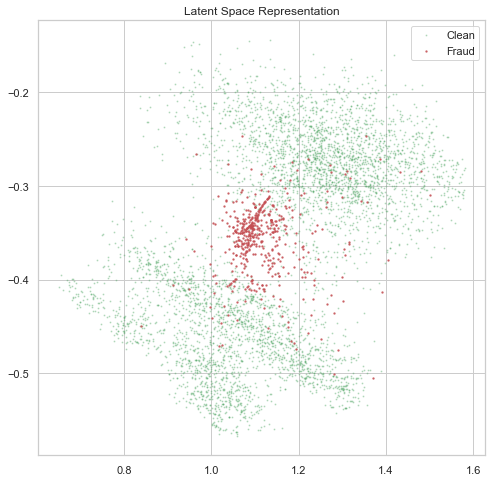

In [34]:
X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Fraud')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()

Although there is no perfectly distinct cluster, **most of the fradulent transactions appear to be neatly grouped together**.
This is in line with the hope/idea that both **classes would occupy distinct areas in latent space**, due to the **encoder's weights not being calibrated to cope with fraudulent transactions**.
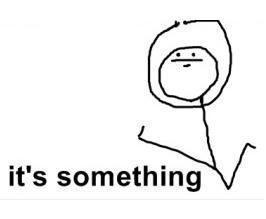

# Conclusion
We could already tell from our misclassifications that the network was not able to generalize perfectly. However, we must not forget that **our model was trained never having seen a single fraud case!** In that regard, its performance is decent. It illustrates the power of **autoencoders as anomaly detection tools**.

To improve its performance, perhaps we need to:
* improve the model architecture
* diversify the training data more, with a broader sample of clean transactions
* augment the data with different, additional features - the data itself might not be good enough to distinguish between classes perfectly (i.e. fraudsters are disguising themselves well enough to always go undetected using these data points, no matter the algorithm).